In [1]:
import json
import os
import torch
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy
import torch.nn as nn
from tqdm import tqdm
from torch.nn.functional import cross_entropy
from torchsummary import summary
from utils import scale_to_unit_range , format_for_display
from DataLoader import EuroSAT
from engine import train_one_epoch , test_one_epoch
from torchvision import datasets , transforms
from torchvision.transforms import ToTensor


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Solo/Solo/e/SOL-39


In [2]:
# Hyperparameters
transform = transforms.Compose([
    ToTensor() , 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ,    
])
BATCH_SIZE = 8 
LR = 0.001
Epochs = 25 
device = 'cuda' if torch.cuda.is_available() else "cpu"
device


'cuda'

Dataset Prep

In [3]:
train_csv = pd.read_csv("EuroSAT/train.csv" , index_col = 0)
test_csv = pd.read_csv("EuroSAT/test.csv" , index_col = 0)
val_csv = pd.read_csv("EuroSAT/validation.csv" , index_col = 0)

train_csv = train_csv.sort_values(axis = 0 , by = ['ClassName'])
test_csv = test_csv.sort_values(axis = 0 , by = ['ClassName'])
val_csv = val_csv.sort_values(axis = 0 , by = ['ClassName'])

In [4]:
with open("EuroSAT/label_map.json" , 'r') as file:
    labels = json.load(file)
    class_names = list(labels.keys())
class_names 

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [5]:
train_set = []
test_set = []
val_set = []
sets = [train_csv , val_csv , test_csv]

for i , set in enumerate(sets):
    if i == 0:
        for index, row in set.iterrows():
            train_set.append(list(row))
    elif i == 2:
        for index, row in set.iterrows():
            test_set.append(list(row))
            
    else: 
        for index, row in set.iterrows():
            val_set.append(list(row))           

In [6]:
train = EuroSAT(parent_dir = "EuroSAT" , data = train_set , transform = transform)
val = EuroSAT(parent_dir = "EuroSAT" , data = val_set , transform = transform)
test = EuroSAT(parent_dir = "EuroSAT" , data = test_set , transform = transform)

len(train) , len(val) , len(test)

(18900, 5400, 2700)

In [7]:
train_loader = torch.utils.data.DataLoader(train , shuffle = True , batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val , shuffle = True , batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, shuffle = True , batch_size=BATCH_SIZE)

len(train_loader) , len(val_loader)  , len(test_loader)

(2363, 675, 338)

Visualize some samples

In [ ]:
train_iter = iter(train_loader)
first_batch = next(train_iter)
images , labels  = first_batch

images.shape , labels.shape

In [ ]:
formatted_images = format_for_display(images)
    
images[0].shape , formatted_images[0].shape

In [ ]:
nrows = 2
ncolumns = 4
fig, axs = plt.subplots(nrows, ncolumns, figsize=(15, 6))

# Flatten the axs array to simplify accessing individual subplots
axs = axs.flatten()

for i in range(len(images)):
    ax = axs[i]  # Access the individual subplot
    ax.imshow(formatted_images[i])  # Display the image
    ax.set_title(class_names[labels[i]])  # Set the title to the class name of the image
    ax.axis('off')  # Hide the axis

plt.show()

NN using Pytorch library

In [8]:
from Classifiers import NN_1 , NN_2

model = NN_2().to(device)
optimizer = torch.optim.Adam(model.parameters() , lr = LR)
cross_entropy = torch.nn.CrossEntropyLoss()
scheduler = "exponential"
if scheduler == "onecyclelr":
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=Epochs, pct_start=0.2)
elif scheduler == "multi_step_lr":
    lr_drop_list = [4, 8]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_drop_list)
elif scheduler == "step_lr":
    step_size = 10
    gamma = 0.5
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size , gamma = gamma)
else:
    gamma = 0.95
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer , gamma)
summary(model , input_size=( 3 , 64 , 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
       BatchNorm2d-2           [-1, 16, 62, 62]              32
              ReLU-3           [-1, 16, 62, 62]               0
            Conv2d-4           [-1, 32, 60, 60]           4,640
       BatchNorm2d-5           [-1, 32, 60, 60]              64
              ReLU-6           [-1, 32, 60, 60]               0
            Conv2d-7           [-1, 64, 56, 56]          51,264
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        LogSoftmax-9           [-1, 64, 56, 56]               0
          Flatten-10               [-1, 200704]               0
           Linear-11                  [-1, 128]      25,690,240
           Linear-12                   [-1, 64]           8,256
           Linear-13                   [-1, 32]           2,080
           Linear-14                   

/home/hasanmog/paper2code/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [9]:
out_dir = 'weights/NN_attempt_2/best_checkpoint.pth'
train_loss , val_loss , current_lr = train_one_epoch(model ,
                                     training_loader=train_loader ,
                                     validation_loader = val_loader ,
                                     optimizer=optimizer ,
                                     lr_scheduler = lr_scheduler , 
                                     epochs = Epochs , 
                                     loss_func = cross_entropy ,
                                     device = device ,
                                     out_dir = out_dir) 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch number : 1
current_lr 0.00095
Final Training loss: 16.385680066293144
Validation Loss: 1.1167823941177792
Validation Accuracy 59.370370370370374


  4%|▍         | 1/25 [00:23<09:30, 23.79s/it]

Epoch number : 2
current_lr 0.0009025
Final Training loss: 2.9962594346760114
Validation Loss: 4.818754993699215
Validation Accuracy 53.48148148148149


  8%|▊         | 2/25 [00:47<09:07, 23.82s/it]

Epoch number : 3
current_lr 0.000857375
Final Training loss: 3.134586571341647


 12%|█▏        | 3/25 [01:11<08:45, 23.88s/it]

Validation Loss: 3.960631590242739
Validation Accuracy 49.407407407407405
Epoch number : 4
current_lr 0.0008145062499999999
Final Training loss: 2.364076920894183


 16%|█▌        | 4/25 [01:35<08:23, 23.96s/it]

Validation Loss: 0.712173409089446
Validation Accuracy 55.69444444444444
Epoch number : 5
current_lr 0.0007737809374999998
Final Training loss: 2.0274440002285963


 20%|██        | 5/25 [01:59<08:01, 24.06s/it]

Validation Loss: 1.1717538045815847
Validation Accuracy 56.51481481481482
Epoch number : 6
current_lr 0.0007350918906249997
Final Training loss: 1.1477178874237592


 24%|██▍       | 6/25 [02:24<07:37, 24.10s/it]

Validation Loss: 1.7121476513257734
Validation Accuracy 56.407407407407405
Epoch number : 7
current_lr 0.0006983372960937497
Final Training loss: 1.3515841026384094


 28%|██▊       | 7/25 [02:48<07:12, 24.05s/it]

Validation Loss: 0.8820742627812757
Validation Accuracy 58.71428571428572
Epoch number : 8
current_lr 0.0006634204312890621
Final Training loss: 1.0596546513683482


 32%|███▏      | 8/25 [03:11<06:47, 23.96s/it]

Validation Loss: 0.8002474047022837
Validation Accuracy 60.38425925925925
Epoch number : 9
current_lr 0.000630249409724609
Final Training loss: 0.9049638954204654


 36%|███▌      | 9/25 [03:34<06:19, 23.71s/it]

Validation Loss: 0.615173317755538
Validation Accuracy 62.34979423868313
Epoch number : 10
current_lr 0.0005987369392383785
Final Training loss: 0.7872143647346962


 40%|████      | 10/25 [03:58<05:52, 23.51s/it]

Validation Loss: 0.5519633432201765
Validation Accuracy 64.17222222222222
Epoch number : 11
current_lr 0.0005688000922764595
Final Training loss: 0.7676273707711894


 44%|████▍     | 11/25 [04:21<05:28, 23.46s/it]

Validation Loss: 0.537347165648653
Validation Accuracy 65.71380471380472
Epoch number : 12
current_lr 0.0005403600876626365
Final Training loss: 0.6826395514383525


 48%|████▊     | 12/25 [04:45<05:05, 23.53s/it]

Validation Loss: 0.655356532704706
Validation Accuracy 66.88888888888889
Epoch number : 13
current_lr 0.0005133420832795047
Final Training loss: 0.6823161241159567


 52%|█████▏    | 13/25 [05:08<04:43, 23.61s/it]

Validation Loss: 0.7162186385691166
Validation Accuracy 67.49145299145299
Epoch number : 14
current_lr 0.00048767497911552944
Final Training loss: 0.6695358745405554


 56%|█████▌    | 14/25 [05:32<04:18, 23.51s/it]

Validation Loss: 0.4621221958887246
Validation Accuracy 68.71693121693121
Epoch number : 15
current_lr 0.00046329123015975297
Final Training loss: 0.567559413040503


 60%|██████    | 15/25 [05:55<03:55, 23.54s/it]

Validation Loss: 0.46210415295808127
Validation Accuracy 69.82716049382715
Epoch number : 16
current_lr 0.0004401266686517653
Final Training loss: 0.5564769299519459


 64%|██████▍   | 16/25 [06:18<03:30, 23.37s/it]

Validation Loss: 0.6243266205103309
Validation Accuracy 70.47569444444444
Epoch number : 17
current_lr 0.00041812033521917703
Final Training loss: 0.5932300263035205


 68%|██████▊   | 17/25 [06:41<03:06, 23.33s/it]

Validation Loss: 0.5112010833736578
Validation Accuracy 71.21459694989106
Epoch number : 18
current_lr 0.00039721431845821814
Final Training loss: 0.49106787548743747


 72%|███████▏  | 18/25 [07:04<02:42, 23.23s/it]

Validation Loss: 0.4145161213277391
Validation Accuracy 72.06893004115227
Epoch number : 19
current_lr 0.0003773536025353072
Final Training loss: 0.4517103946192125


 76%|███████▌  | 19/25 [07:28<02:19, 23.21s/it]

Validation Loss: 0.7338381758597852
Validation Accuracy 72.42495126705653
Epoch number : 20
current_lr 0.0003584859224085418
Final Training loss: 0.535035810434412


 80%|████████  | 20/25 [07:51<01:56, 23.25s/it]

Validation Loss: 0.4328612029654215
Validation Accuracy 73.12129629629631
Epoch number : 21
current_lr 0.0003405616262881147
Final Training loss: 0.42055217608787004


 84%|████████▍ | 21/25 [08:15<01:33, 23.37s/it]

Validation Loss: 0.49871181310378704
Validation Accuracy 73.68606701940035
Epoch number : 22
current_lr 0.00032353354497370894
Final Training loss: 0.416680916106405


 88%|████████▊ | 22/25 [08:38<01:10, 23.39s/it]

Validation Loss: 0.44599451415723673
Validation Accuracy 74.22727272727273
Epoch number : 23
current_lr 0.00030735686772502346
Final Training loss: 0.3900950846702134


 92%|█████████▏| 23/25 [09:02<00:47, 23.56s/it]

Validation Loss: 0.45147121449865624
Validation Accuracy 74.7818035426731
Epoch number : 24
current_lr 0.00029198902433877225
Final Training loss: 0.3604561209930054


 96%|█████████▌| 24/25 [09:26<00:23, 23.73s/it]

Validation Loss: 0.4591718388769638
Validation Accuracy 75.29089506172839
Epoch number : 25
current_lr 0.00027738957312183364
Final Training loss: 0.3559940013520802


100%|██████████| 25/25 [09:50<00:00, 23.61s/it]

Validation Loss: 0.7554572190000477
Validation Accuracy 75.5474074074074
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/Solo/Solo/e/SOL-39/metadata


In [13]:
checkpoint = torch.load("weights/NN_attempt_2/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
model.to(device)
test_loss = test_one_epoch(model = model , test_loader= test_loader , loss_func=cross_entropy , device = device)

Test Loss: 4.758614252040372
Accuracy: 47.77777777777778


In [11]:
test_iter = iter(test_loader)
first_batch = next(test_iter)
images , labels  = first_batch

with torch.no_grad():
    logits = model(images).to('cpu')
logits = logits.numpy()
pred_classes = np.argmax(logits, axis=1)
pred_classes

array([1, 4, 4, 7, 1, 7, 7, 1])

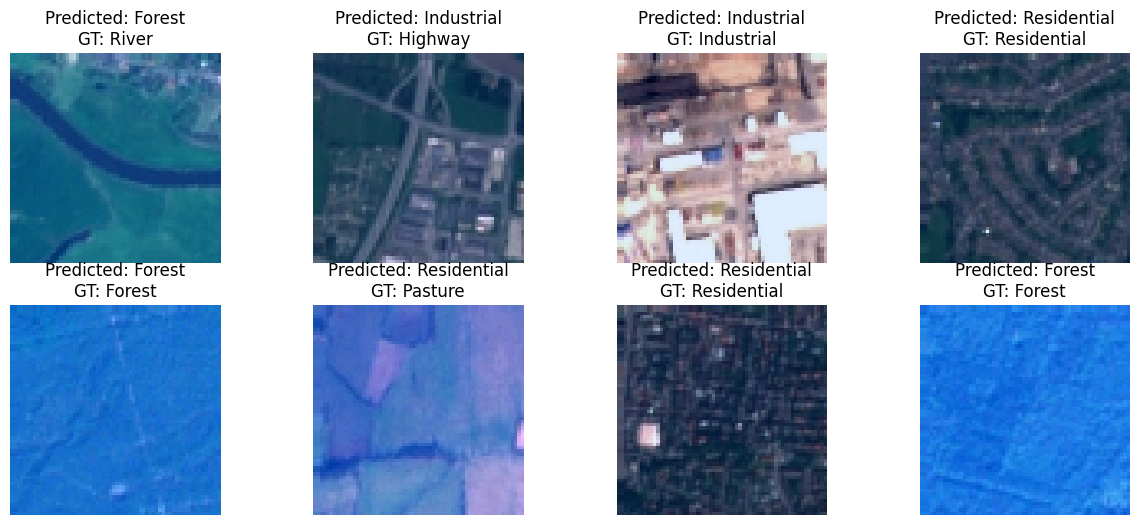

In [12]:
formatted_images  = format_for_display(images)
nrows = 2
ncolumns = 4
fig, axs = plt.subplots(nrows, ncolumns, figsize=(15, 6))

# Flatten the axs array to simplify accessing individual subplots
axs = axs.flatten()

# Ensure you have a variable called class_names that maps label indices to actual names
# e.g., class_names = {0: 'cat', 1: 'dog', ...}

for i in range(len(formatted_images)):
    ax = axs[i]  # Access the individual subplot
    ax.imshow(formatted_images[i])  # Assuming images[i] is a torch tensor; permute to change the channel order for matplotlib
    # Include both GT and predicted class names in the title
    title = f'Predicted: {class_names[pred_classes[i]]}\nGT: {class_names[labels[i].item()]}'
    ax.set_title(title)
    ax.axis('off')  # Hide the axis

# Adjust the layout to prevent the titles from overlapping

plt.show()
